# Multiplier-accelerator model; Kernel estimation assignment
(5/5)

Install and import packages needed

In [2]:
!pip install quantecon

#Imports for first question
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from quantecon import LinearStateSpace
import cmath
import math
import sympy
from sympy import Symbol, init_printing
from cmath import sqrt


#Imports needed for question 3
from scipy.stats import norm
import scipy.stats

ERROR: Invalid requirement: '#needed'


## First Question

Construct a version of the Samuelson model that has neither damped nor explosive roots that has period 16.  I am thinking of quarters as the unit of time, and 16 quarters is a Presidential cycle. The three initial conditions are $Y_0=Y_1=Y_2 = 656.8535592272043$. There is no government spending.  (Hint: use the fact that $I_2 = 0$ implies that $Y_2 = C_2$. This will help you solve for gamma.)  Give the consumption function, the investment function, and the GDP identity.  Plot the deterministic version of the model for 100 periods.

In [3]:
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size

In [4]:
def categorize_solution(ρ1, ρ2):

    """This function takes values of ρ1 and ρ2 and uses them
    to classify the type of solution
    """

    discriminant = ρ1 ** 2 + 4 * ρ2
    if ρ2 > 1 + ρ1 or ρ2 < -1:
        print('Explosive oscillations')
    elif ρ1 + ρ2 > 1:
        print('Explosive growth')
    elif discriminant < 0:
        print('Roots are complex with modulus less than one; \
therefore damped oscillations')
    else:
        print('Roots are real and absolute values are less than one; \
therefore get smooth convergence to a steady state')

In [5]:
##=== This method uses numpy to calculate roots ===#


def y_nonstochastic(y_0=100, y_1=80, α=.9, β=.8, γ=10, n=80):

    """ Rather than computing the roots of the characteristic
    polynomial by hand as we did earlier, this function
    enlists numpy to do the work for us
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    categorize_solution(ρ1, ρ2)

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])
    print(f'Roots are {roots}')

    # Check if real or complex
    if all(isinstance(root, complex) for root in roots):
        print('Roots are complex')
    else:
        print('Roots are real')

    # Check if roots are less than one
    if all(abs(root) < 1 for root in roots):
        print('Roots are less than one')
    else:
        print('Roots are not less than one')

    # Define transition equation
    def transition(x, t): return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ

    # Set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):
        y_t.append(transition(y_t, t))

    return y_t



In [6]:
def plot_y(function=None):

    """Function plots path of Y_t"""

    plt.subplots(figsize=(10, 6))
    plt.plot(function)
    plt.xlabel('Time $t$', fontsize=20)
    plt.ylabel('$Y_t$', fontsize=20, rotation=0)
    #plt.grid()
    plt.show()

In [7]:
### code to reverse-engineer a cycle
### y_t = r^t (c_1 cos(ϕ t) + c2 sin(ϕ t))
###

def f(r, ϕ):
    """
    Takes modulus r and angle ϕ of complex number r exp(j ϕ)
    and creates ρ1 and ρ2 of characteristic polynomial for which
    r exp(j ϕ) and r exp(- j ϕ) are complex roots.

    Returns the multiplier coefficient a and the accelerator coefficient b
    that verifies those roots.
    """
    g1 = cmath.rect(r, ϕ)  # Generate two complex roots
    g2 = cmath.rect(r, -ϕ)
    ρ1 = g1 + g2           # Implied ρ1, ρ2
    ρ2 = -g1 * g2
    b = -ρ2                # Reverse-engineer a and b that validate these
    a = ρ1 - b
    return ρ1, ρ2, a, b

## Now let's use the function in an example
## Here are the example parameters

r = 1
period = 16                # Length of cycle in units of time
ϕ = 2 * math.pi/period

## Apply the function

ρ1, ρ2, a, b = f(r, ϕ)

print(f"a, b = {a}, {b}")
print(f"ρ1, ρ2 = {ρ1}, {ρ2}")

a, b = (0.8477590650225735+0j), (1-0j)
ρ1, ρ2 = (1.8477590650225735+0j), (-1+0j)


a, b = 0.8477590650225735, 1.0
Roots are complex with modulus less than one; therefore damped oscillations
Roots are [0.92387953+0.38268343j 0.92387953-0.38268343j]
Roots are complex
Roots are not less than one


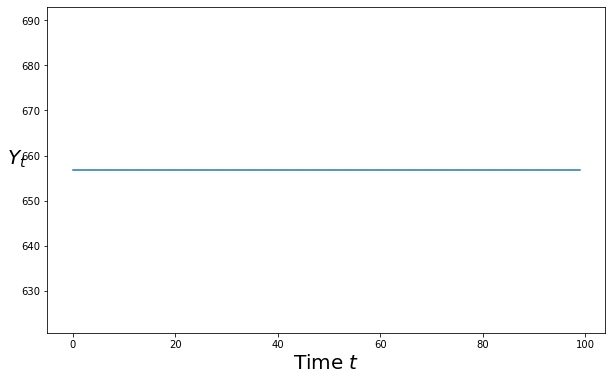

In [8]:
r = 1   # Generates undamped, nonexplosive cycles

period = 16   # Length of cycle in units of time
ϕ = 2 * math.pi/period

## Apply the reverse-engineering function f

ρ1, ρ2, a, b = f(r, ϕ)

# Drop the imaginary part so that it is a valid input into y_nonstochastic
a = a.real
b = b.real

print(f"a, b = {a}, {b}")

ytemp = y_nonstochastic(α = a, β = b, y_0 = 656.8535592272043, y_1 = 656.8535592272043, γ = 100, n = 100)
plot_y(ytemp)

## Second Question

Now simulate a Presidential election using a stochastic version of the model with the same parameters.  The candidate is elected in period 16, and she implements a one-off government spending of 10.  Keep the variance of the shock for the method   y_stochastic_g(...) at $\sigma = 2$, but use this random seed np.random.seed(1234), so that I can grade your homework.  Plot the stochastic version of the model for 100 periods.  Do you think government spending induces the business cycle?

Roots are complex with modulus less than one; therefore damped oscillations
[0.92387953+0.38268343j 0.92387953-0.38268343j]
Roots are complex
Roots are not less than one


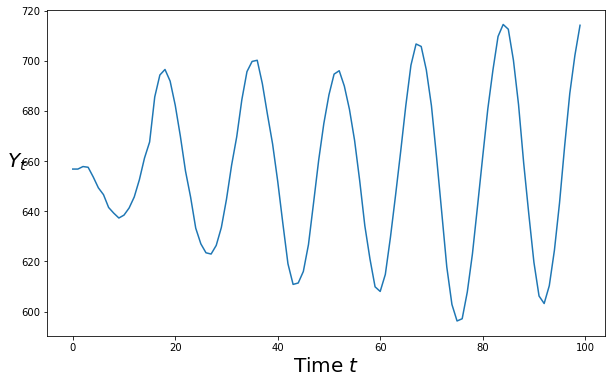

In [9]:
def y_stochastic_g(y_0=20,
                   y_1=20,
                   α=0.8477590650225735,
                   β=1,
                   γ=10,
                   n=100,
                   σ=2,
                   g=0,
                   g_t=0,
                   duration='permanent'):

    """This program computes a response to a permanent increase
    in government expenditures that occurs at time 20
    """

    # Useful constants
    ρ1 = α + β
    ρ2 = -β

    # Categorize solution
    categorize_solution(ρ1, ρ2)

    # Find roots of polynomial
    roots = np.roots([1, -ρ1, -ρ2])
    print(roots)

    # Check if real or complex
    if all(isinstance(root, complex) for root in roots):
        print('Roots are complex')
    else:
        print('Roots are real')

    # Check if roots are less than one
    if all(abs(root) < 1 for root in roots):
        print('Roots are less than one')
    else:
        print('Roots are not less than one')

    # Generate shocks
    ϵ = np.random.normal(0, 1, n)

    def transition(x, t, g):

        # Non-stochastic - separated to avoid generating random series
        # when not needed
        if σ == 0:
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g

        # Stochastic
        else:
            ϵ = np.random.normal(0, 1, n)
            return ρ1 * x[t - 1] + ρ2 * x[t - 2] + γ + g + σ * ϵ[t]

    # Create list and set initial conditions
    y_t = [y_0, y_1]

    # Generate y_t series
    for t in range(2, n):

        # No government spending
        if g == 0:
            y_t.append(transition(y_t, t))

        # Government spending (no shock)
        elif g != 0 and duration == None:
            y_t.append(transition(y_t, t))

        # Permanent government spending shock
        elif duration == 'permanent':
            if t < g_t:
                y_t.append(transition(y_t, t, g=0))
            else:
                y_t.append(transition(y_t, t, g=g))

        # One-off government spending shock
        elif duration == 'one-off':
            if t == g_t:
                y_t.append(transition(y_t, t, g=g))
            else:
                y_t.append(transition(y_t, t, g=0))
    return y_t
np.random.seed(1234)
plot_y(y_stochastic_g(y_0 = 656.8535592272043, y_1 = 656.8535592272043, γ = 100, g = 10, g_t = 16, duration = "one-off"))

>Yes, I think government spending induces business cycle. The government can use tools such as fiscal and/or monetary policies to induce the business cycle. The government also has the power to do certain things such as increasing or decreasing the interest rates that have a massive impact on business. Doing a little bit of research this question seems to be very popular in the business world with varying answers. Economists Ramey and Zubairy, claim there is no consensus on whether increasing government spending is an effective policy measure to lift the economy up during recessions. 

## Third Question

Last year, there were 35 students in Econ 512.  They graciously assented to writing down their weights in pounds.  Below  is the resulting array of data. Use kernel estimation to estimate the distribution from which the students weights were drawn. Plot the estimated distribution using the grid from 90 to 230 with an interval being one pound.  In your plot, also include the default histogram.  Give your best guess of how many women and how many men were in the class last year.

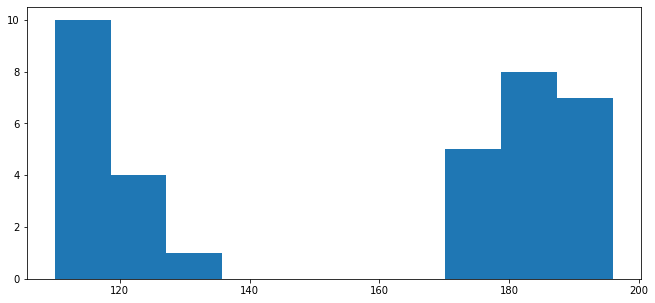

In [10]:
jdata = [182,
 127,
 117,
 187,
 110,
 176,
 189,
 174,
 112,
 112,
 115,
 171,
 119,
 179,
 172,
 189,
 195,
 125,
 116,
 182,
 181,
 186,
 196,
 110,
 111,
 129,
 193,
 122,
 189,
 118,
 171,
 110,
 186,
 194,
 183]

jdata = np.array(jdata)
plt.hist(jdata)
plt.show()

In [11]:
K = norm.pdf

class KDE:

    def __init__(self, x_data, h=None):

        if h is None:
            c = x_data.std()
            n = len(x_data)
            h = 1.06 * c * n**(-1/5)
        self.h = h
        self.x_data = x_data

    def f(self, x):
        if np.isscalar(x):
            return K((x - self.x_data) / self.h).mean() * (1/self.h)
        else:
            y = np.empty_like(x)
            for i, x_val in enumerate(x):
                y[i] = K((x_val - self.x_data) / self.h).mean() * (1/self.h)
            return y

In [12]:
def plot_kde(ϕ, x_min=-90, x_max=230):
    #x_data = ϕ.rvs(n)
    kde = KDE(jdata) #KernelDensity(kernel = "tophat").fit(x_data)

    x_grid = np.linspace(x_min, x_max, 141)
    fig, ax = plt.subplots()
    ax.plot(x_grid, kde.f(x_grid), label="Estimate")
    ax.hist(jdata, density = True, label="Histogram of Weight Density", bins = 20)
    ax.legend()
    plt.show()

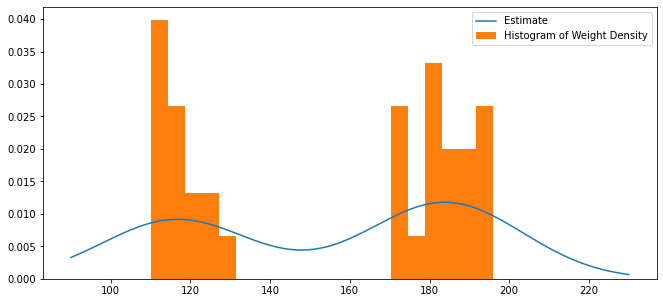

In [13]:
plot_kde(jdata, x_min = 90, x_max = 230)

>Looking at the graph above I would say that about 1/3rd of the cohort were women. Just by looking at the weights you could come to the conclusion that anyone who weighs less than 130lbs is a woman, but this kernel estimation makes it easier to tell since it clearly divides the cohort into two (I am interpreting it as women and men). I am able to come to this conclusion by understanding the kernel estimation is used to see the probability distribution of the cohort.  